# **GREEN SHEILD - AI for Plant Diesease Detection**

### Data Exploration

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install tqdm

In [2]:
# Importing Necessary Libraries
import os
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
import shutil
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch
from torchvision import transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.optim as optim
from torch.amp import autocast, GradScaler
from tqdm import tqdm
import copy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import cv2




In [9]:
dataset_path = "/content/drive/MyDrive/green/all_dataset/color"
subcategories = os.listdir(dataset_path)
print("Subcategories in color :", subcategories)

Subcategories in color : ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites 

In [10]:
total_images = 0
for subcategory in subcategories:
     subcategory_path = os.path.join(dataset_path, subcategory)
     if os.path.isdir(subcategory_path):
         num_images = len(os.listdir(subcategory_path))
         total_images += num_images
         print(f"Subcategory: {subcategory} - {num_images} images")

# Total number of images
print(f"\nTotal images in dataset: {total_images}")


Subcategory: Apple___Apple_scab - 630 images
Subcategory: Apple___Black_rot - 621 images
Subcategory: Apple___Cedar_apple_rust - 275 images
Subcategory: Apple___healthy - 1645 images
Subcategory: Blueberry___healthy - 1502 images
Subcategory: Cherry_(including_sour)___healthy - 854 images
Subcategory: Cherry_(including_sour)___Powdery_mildew - 1052 images
Subcategory: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot - 513 images
Subcategory: Corn_(maize)___Common_rust_ - 1192 images
Subcategory: Corn_(maize)___healthy - 1162 images
Subcategory: Corn_(maize)___Northern_Leaf_Blight - 985 images
Subcategory: Grape___Black_rot - 1180 images
Subcategory: Grape___Esca_(Black_Measles) - 1383 images
Subcategory: Grape___healthy - 423 images
Subcategory: Grape___Leaf_blight_(Isariopsis_Leaf_Spot) - 1076 images
Subcategory: Orange___Haunglongbing_(Citrus_greening) - 5507 images
Subcategory: Peach___Bacterial_spot - 2297 images
Subcategory: Peach___healthy - 360 images
Subcategory: Pepper,_bell

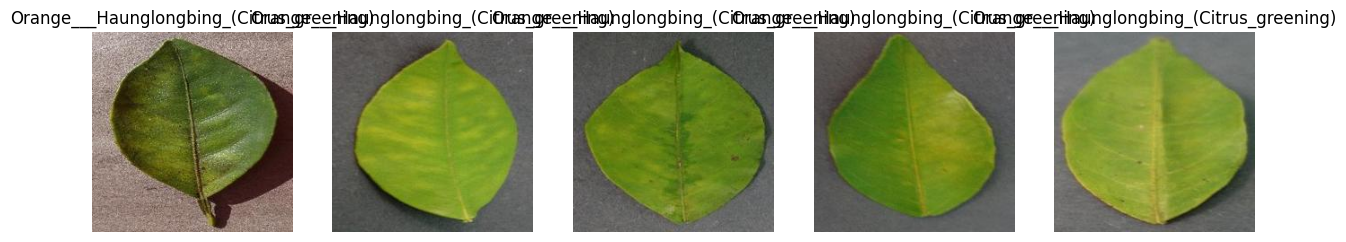

In [ ]:
# random images
sample_subcategory = subcategories[0]
sample_path = os.path.join(dataset_path, sample_subcategory)


sample_images = os.listdir(sample_path)

# few images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, img_name in enumerate(sample_images[:5]):
     img_path = os.path.join(sample_path, img_name)
     img = Image.open(img_path)
     axes[i].imshow(img)
     axes[i].axis("off")
     axes[i].set_title(sample_subcategory)
plt.show()


### Data Preprocessing + Augmentation

##### Looking for corrupted images

In [ ]:

def check_image_validity(directory):
    corrupt_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(root, file)
                try:
                    with Image.open(path) as img:
                        img.verify()
                except (UnidentifiedImageError, OSError):
                    corrupt_files.append(path)
    return corrupt_files

# check corruption
corrupt = check_image_validity("/content/drive/MyDrive/green/all_dataset/color")
print(f"Found {len(corrupt)} corrupted images.")


Found 0 corrupted images.


In [ ]:
# change

corrupt_path = "/path/to/corrupted/image.jpg"
if os.path.exists(corrupt_path):
    os.remove(corrupt_path)
print("Corrupted image deleted.")


##### Train Test dataset split

In [4]:
dataset_path = "/content/drive/MyDrive/green/all_dataset/color"
train_dir = "/content/drive/MyDrive/green/all_dataset/train"
test_dir = "/content/drive/MyDrive/green/all_dataset/test"

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)



In [5]:
# Splitting the dataset into Train-Test
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)

    if os.path.isdir(category_path):
        img_list = os.listdir(category_path)
        train_imgs, test_imgs = train_test_split(img_list, train_size=0.8, random_state=42)

        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(test_dir, category), exist_ok=True)

        for img in train_imgs:
            shutil.copy(os.path.join(category_path, img), os.path.join(train_dir, category, img))

        for img in test_imgs:
            shutil.copy(os.path.join(category_path, img), os.path.join(test_dir, category, img))

##### Resizing images

In [6]:
# size of images
target_size = (224, 224)

# Resize
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)

    if os.path.isdir(category_path):
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)

            try:
                img = Image.open(img_path)
                if img.size != target_size:
                    img_resized = img.resize(target_size)
                    img_resized.save(img_path)
            except Exception as e:
                print(f"Error processing {img_path}: {e}")


In [7]:
if all(Image.open(os.path.join(category_path, img)).size == (224, 224) for img in os.listdir(category_path)):
    print("All images have the correct size!")

All images have the correct size!


##### Class Distribution Analysis

Looking in: /content/drive/MyDrive/green/all_dataset/train
Subfolders found: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'T

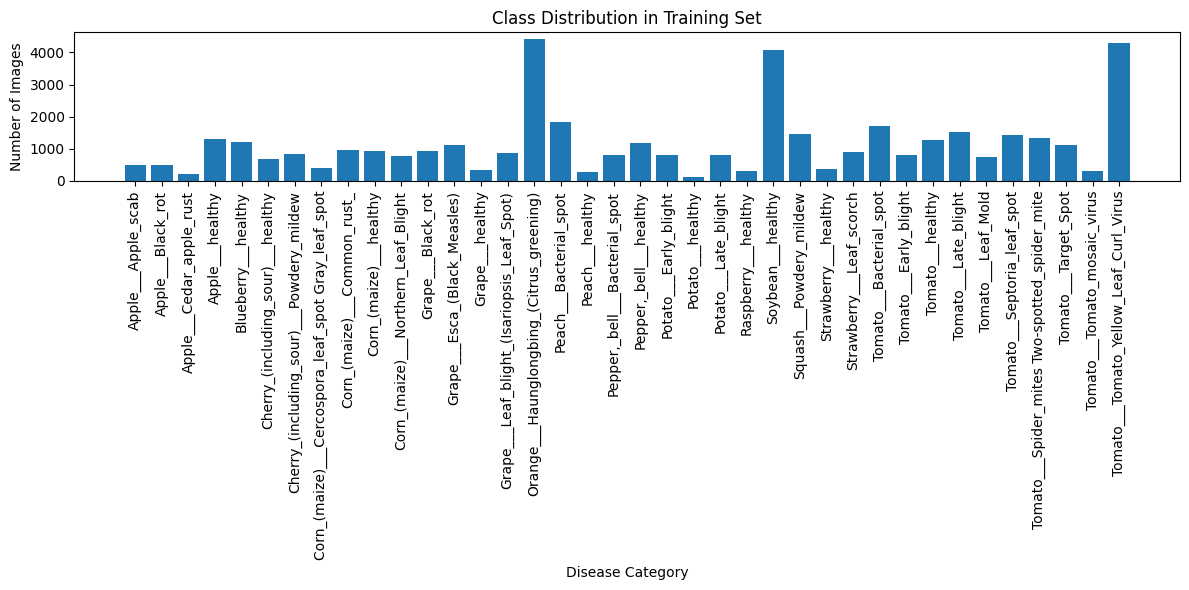

In [7]:
train_dir ="/content/drive/MyDrive/green/all_dataset/train"


print("Looking in:", train_dir)
print("Subfolders found:", os.listdir(train_dir))


class_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        count = len([img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))])
        class_counts[class_name] = count

# Debug
print("Class counts:", class_counts)

# Plot the class distribution
if class_counts:
    plt.figure(figsize=(12, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xticks(rotation=90)
    plt.title('Class Distribution in Training Set')
    plt.xlabel('Disease Category')
    plt.ylabel('Number of Images')
    plt.tight_layout()
    plt.show()
else:
    print("No images found or incorrect path.")


In [10]:
# class labels
class_names = sorted(os.listdir("/content/drive/MyDrive/green/all_dataset/train"))

# Image counts
targets = []
for idx, class_name in enumerate(class_names):
    img_dir = os.path.join("/content/drive/MyDrive/green/all_dataset/train", class_name)
    targets.extend([idx] * len(os.listdir(img_dir)))


class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(targets), y=targets)
class_weights = torch.FloatTensor(class_weights)


criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

##### Normalise Image Pixel Values

In [13]:

image_size = 224

train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])



##### Handling class imbalance

In [14]:
class_names = sorted(os.listdir(train_dir))


targets = []
for idx, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    count = len(os.listdir(class_path))
    targets.extend([idx] * count)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(targets), y=targets)
class_weights = torch.FloatTensor(class_weights)

##### Dataloaders with Transforms

In [15]:
train_dir = "/content/drive/MyDrive/green/all_dataset/train"
val_dir = "/content/drive/MyDrive/green/all_dataset/test"


train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

class_names = train_dataset.classes


##### Load EfficientNet

In [16]:
# Load model
model = models.efficientnet_b0(pretrained=True)


num_classes = len(class_names)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 238MB/s]


In [17]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [20]:
class SafeImageFolder(ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        try:
            sample = self.loader(path)
            if self.transform is not None:
                sample = self.transform(sample)
            return sample, target
        except (UnidentifiedImageError, OSError) as e:
            print(f"Skipping corrupted image: {path}")
            dummy = torch.zeros(3, image_size, image_size)
            return dummy, -1


def collate_fn(batch):
    batch = [item for item in batch if item[1] != -1]
    return torch.utils.data.dataloader.default_collate(batch)

In [21]:
image_size = 224
batch_size = 32
num_epochs = 15
lr = 0.0005

In [22]:
# class weights
targets = []
for idx, class_name in enumerate(class_names):
    img_dir = os.path.join(train_dir, class_name)
    targets.extend([idx] * len(os.listdir(img_dir)))
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(targets), y=targets)
class_weights = torch.FloatTensor(class_weights)

In [25]:
# model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
weights = EfficientNet_B0_Weights.DEFAULT
model = efficientnet_b0(weights=weights)
for param in model.features.parameters():
    param.requires_grad = False
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.classifier[1].in_features, len(class_names))
)
model = model.to(device)



Using device: cuda


In [28]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scaler = GradScaler(device=device)

In [31]:
# Training Loop
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_acc_history, val_acc_history = [], []
train_loss_history, val_loss_history = [], []


In [36]:

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 30)

    for phase in ['train', 'val']:
        model.train() if phase == 'train' else model.eval()
        dataloader = train_loader if phase == 'train' else val_loader

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in tqdm(dataloader, desc=f"{phase.capitalize()} Epoch {epoch+1}", leave=False):
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                with autocast(device_type='cuda' if device.type == 'cuda' else 'cpu'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                if phase == 'train':
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

        if phase == 'train':
            train_loss_history.append(epoch_loss)
            train_acc_history.append(epoch_acc.item())
            scheduler.step()
        else:
            val_loss_history.append(epoch_loss)
            val_acc_history.append(epoch_acc.item())
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")


Epoch 1/15
------------------------------


Train Loss: 1.0505 | Acc: 0.8261


Val Loss: 0.4114 | Acc: 0.9121

Epoch 2/15
------------------------------


Train Loss: 0.4247 | Acc: 0.8968


Val Loss: 0.2723 | Acc: 0.9322

Epoch 3/15
------------------------------


Train Loss: 0.3314 | Acc: 0.9128


Val Loss: 0.2384 | Acc: 0.9355

Epoch 4/15
------------------------------


Train Loss: 0.2923 | Acc: 0.9176


Val Loss: 0.2137 | Acc: 0.9401

Epoch 5/15
------------------------------


Train Loss: 0.2657 | Acc: 0.9247


Val Loss: 0.1838 | Acc: 0.9468

Epoch 6/15
------------------------------


Train Loss: 0.2530 | Acc: 0.9247


Val Loss: 0.1746 | Acc: 0.9519

Epoch 7/15
------------------------------


Train Loss: 0.2453 | Acc: 0.9280


Val Loss: 0.1835 | Acc: 0.9485

Epoch 8/15
------------------------------


Train Loss: 0.2408 | Acc: 0.9274


Val Loss: 0.1805 | Acc: 0.9494

Epoch 9/15
------------------------------


Train Loss: 0.2432 | Acc: 0.9275


Val Loss: 0.1713 | Acc: 0.9530

Epoch 10/15
------------------------------


Train Loss: 0.2400 | Acc: 0.9292


Val Loss: 0.1718 | Acc: 0.9507

Epoch 11/15
------------------------------


Train Loss: 0.2313 | Acc: 0.9306


Val Loss: 0.1739 | Acc: 0.9522

Epoch 12/15
------------------------------


Train Loss: 0.2343 | Acc: 0.9292


Val Loss: 0.1749 | Acc: 0.9513

Epoch 13/15
------------------------------


Train Loss: 0.2333 | Acc: 0.9305


Val Loss: 0.1831 | Acc: 0.9481

Epoch 14/15
------------------------------


Train Loss: 0.2412 | Acc: 0.9277


Val Loss: 0.1691 | Acc: 0.9525

Epoch 15/15
------------------------------


Train Loss: 0.2344 | Acc: 0.9306


Val Loss: 0.1666 | Acc: 0.9529



 Training complete. Best validation accuracy: 0.9530


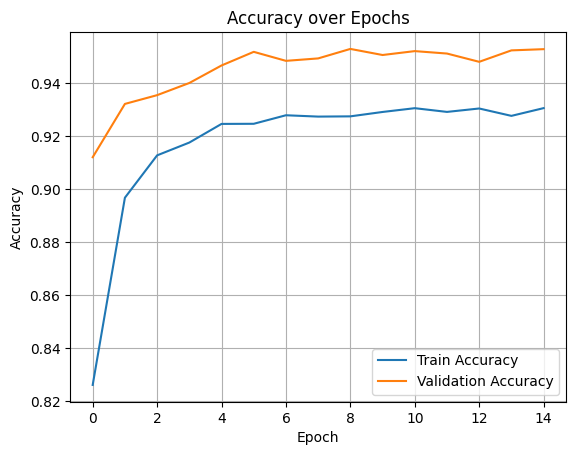

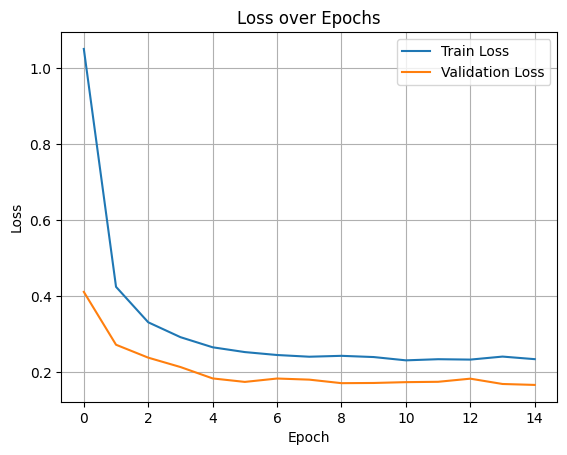

In [37]:
# Best Model
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), "best_efficientnet_model.pth")
print(f"\n Training complete. Best validation accuracy: {best_acc:.4f}")

# Plots
plt.figure()
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\n Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

In [38]:
test_loss = 0.0
test_corrects = 0
test_loader = val_loader

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * inputs.size(0)
        test_corrects += torch.sum(preds == labels.data)

test_loss = test_loss / len(test_loader.dataset)
test_acc = test_corrects.double() / len(test_loader.dataset)

print(f"\n Test Accuracy: {test_acc:.4f}")
print(f" Test Loss: {test_loss:.4f}")



 Test Accuracy: 0.9531
 Test Loss: 0.1713


##### Confusion matrix

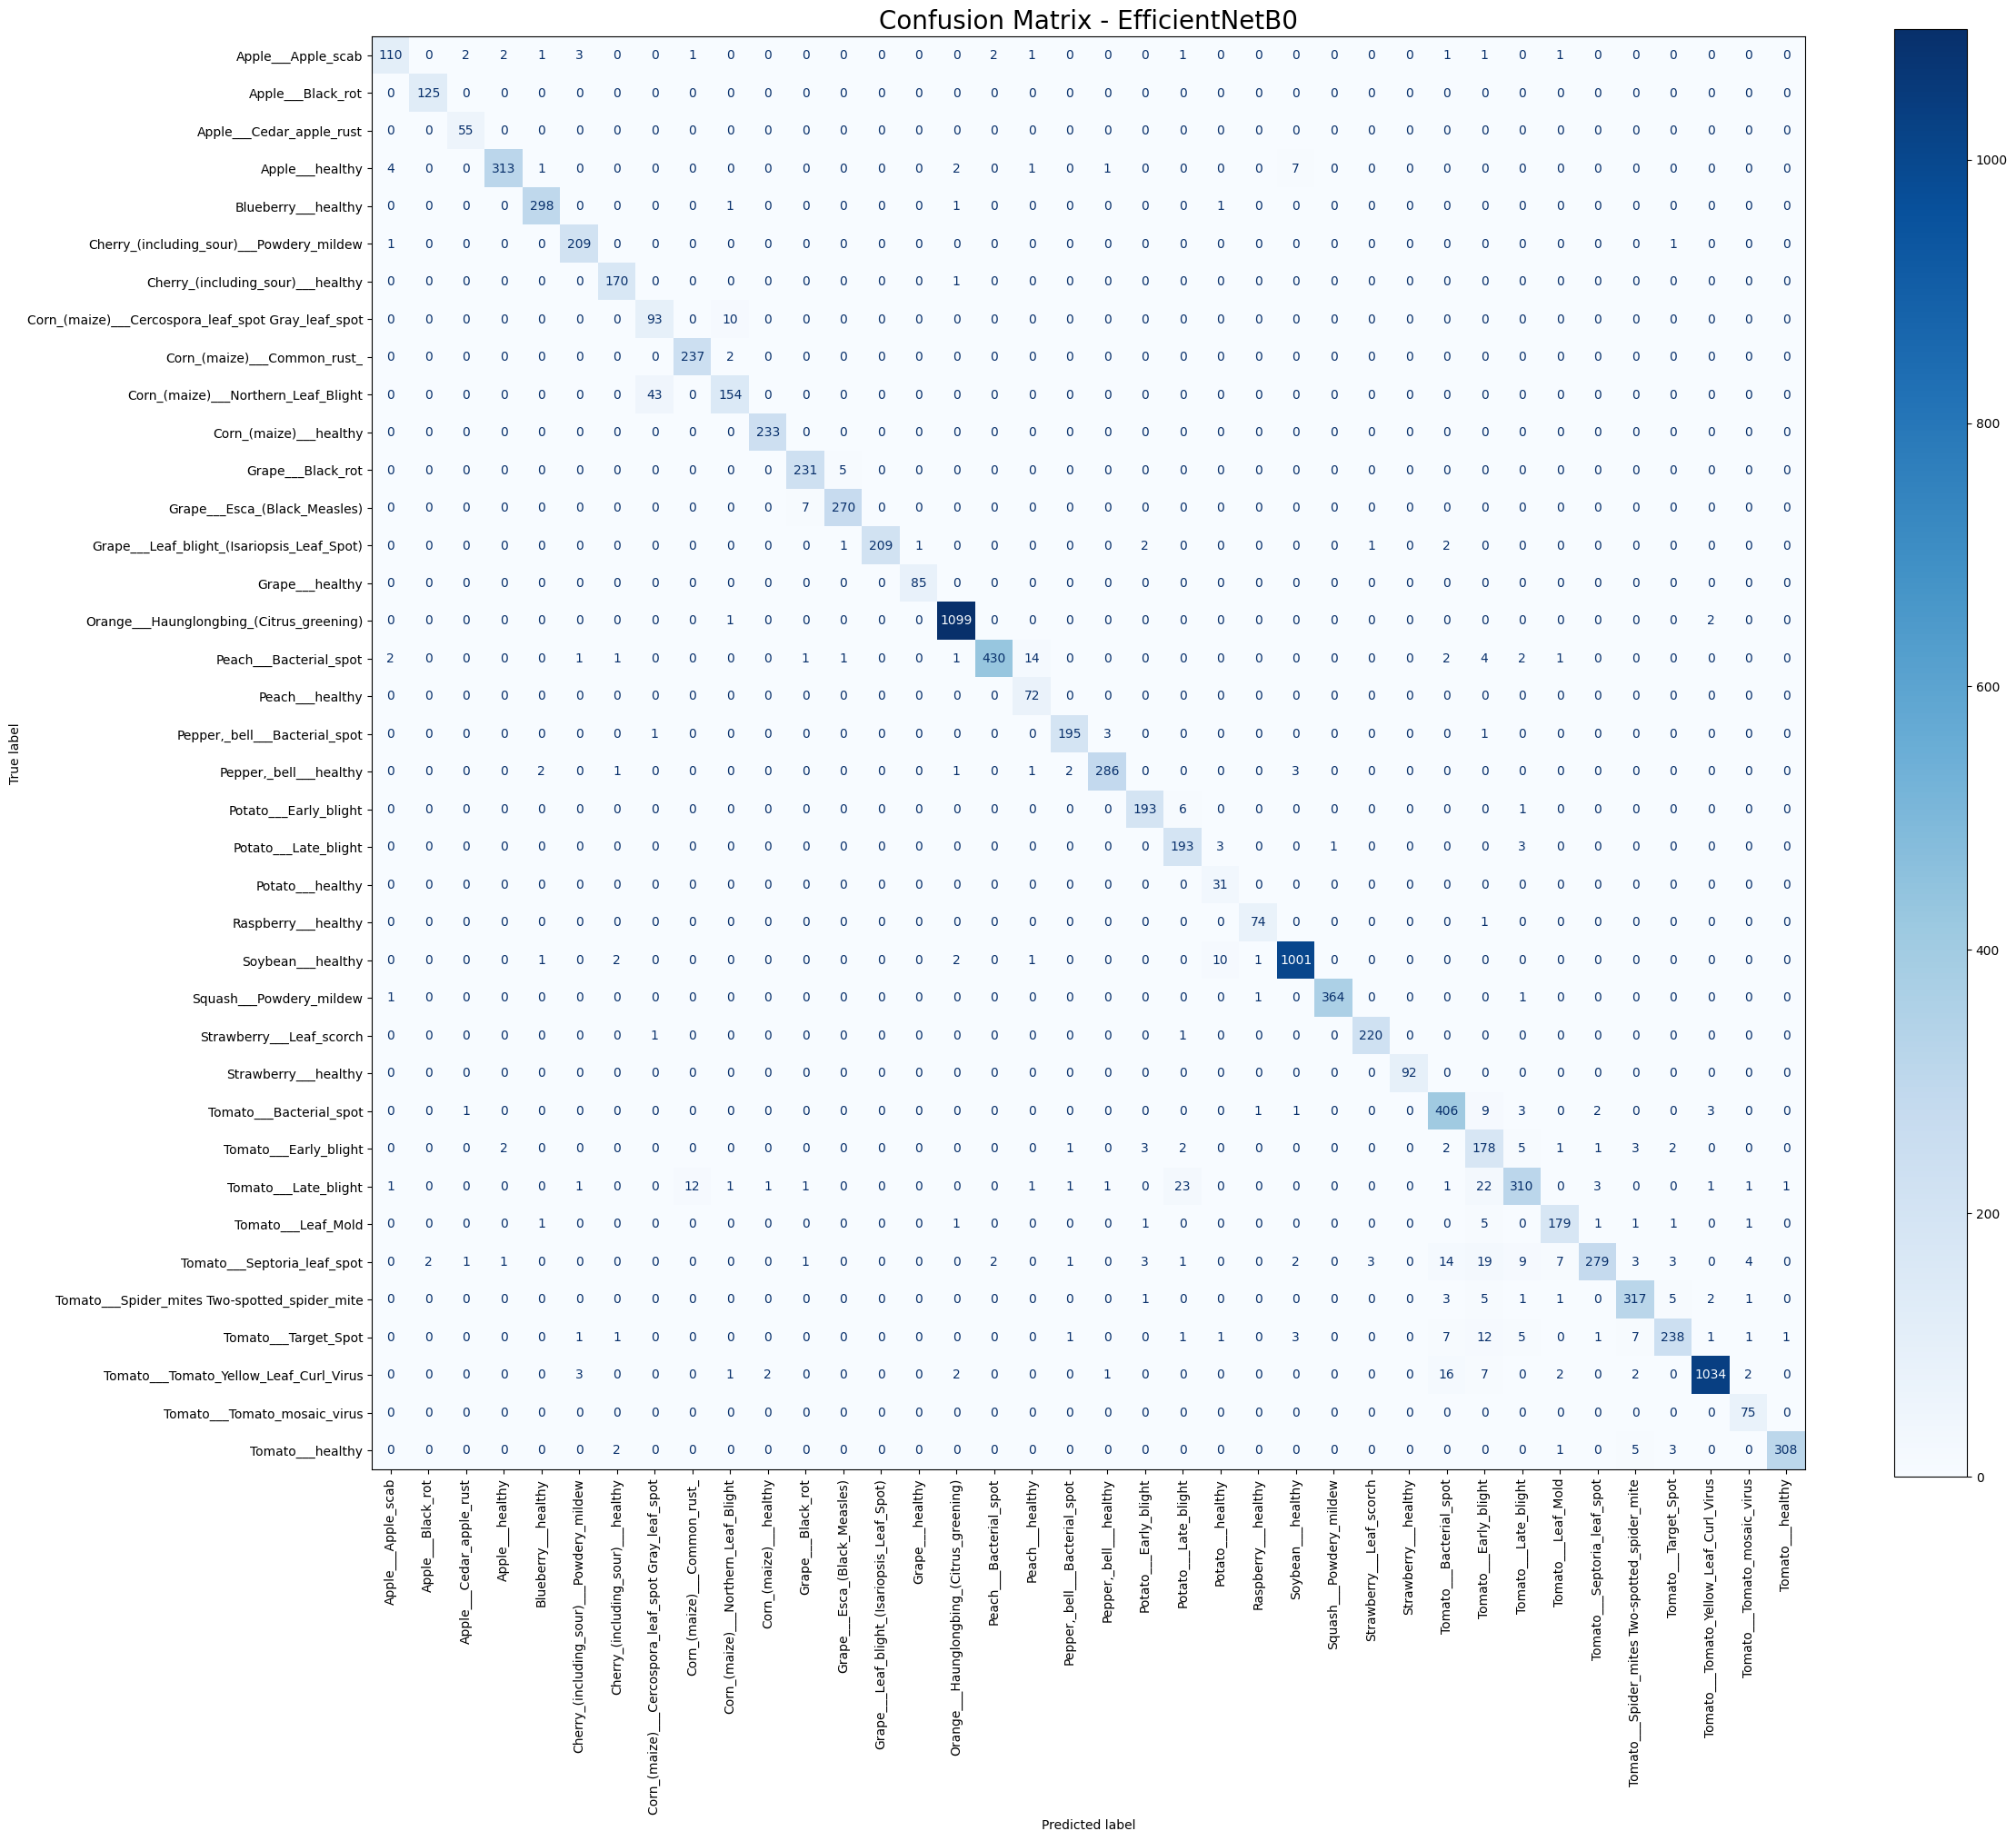

In [42]:

model = efficientnet_b0(weights=None)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)


model.load_state_dict(torch.load("/content/drive/MyDrive/green/all_dataset/models/best_efficientnet_model.pth", map_location='cuda' if torch.cuda.is_available() else 'cpu'))
model = model.to(device)


all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(24, 20))
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues", values_format='d')
plt.title("Confusion Matrix - EfficientNetB0", fontsize=20)
plt.tight_layout()
plt.show()


##### GradCam for EfficientNet


In [48]:


def generate_gradcam(image_path, model_path, class_names, save_path="gradcam.jpg", image_size=224):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")

    # Load model
    model = efficientnet_b0(weights=None)
    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(0.3),
        torch.nn.Linear(model.classifier[1].in_features, len(class_names))
    )
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device).eval()


    gradients, activations = [], []

    def save_gradient(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def save_activation(module, input, output):
        activations.append(output)


    target_layer = model.features[-1][0]
    target_layer.register_forward_hook(save_activation)
    target_layer.register_backward_hook(save_gradient)


    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)


    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()
    print(f"Predicted: {class_names[pred_class]}")

    model.zero_grad()
    output[0, pred_class].backward()

    if not gradients or not activations:
        raise RuntimeError("Gradients or activations not captured. Hook may have failed.")


    grad = gradients[0].squeeze().cpu().detach().numpy()
    act = activations[0].squeeze().cpu().detach().numpy()
    weights = np.mean(grad, axis=(1, 2))

    cam = np.zeros(act.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * act[i]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (image_size, image_size), interpolation=cv2.INTER_CUBIC)
    cam_min, cam_max = cam.min(), cam.max()
    print(f"CAM min: {cam_min}, CAM max: {cam_max}, CAM mean: {cam.mean()}, CAM std: {cam.std()}")
    cam = (cam - cam_min) / (cam_max - cam_min + 1e-8)
    cam[cam < 0.2] = 0


    cam_uint8 = np.uint8(255 * cam)
    heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)


    original_img = np.array(image.resize((image_size, image_size)))
    heatmap_rgb = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    alpha = cam[..., np.newaxis]
    overlay = (1 - alpha) * original_img + alpha * heatmap_rgb
    overlay = np.clip(overlay, 0, 255).astype(np.uint8)


    cv2.imwrite(save_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
    print(f"Grad-CAM saved to: {save_path}")


    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(cam, cmap='jet')
    plt.title("Grad-CAM Heatmap (Raw)")
    plt.colorbar()
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

Predicted: Apple___Black_rot
CAM min: -0.010622908361256123, CAM max: 0.5229291319847107, CAM mean: 0.1471571922302246, CAM std: 0.12345059216022491
Grad-CAM saved to: /content/drive/MyDrive/green/all_dataset/GradCam/EffNet1.jpg


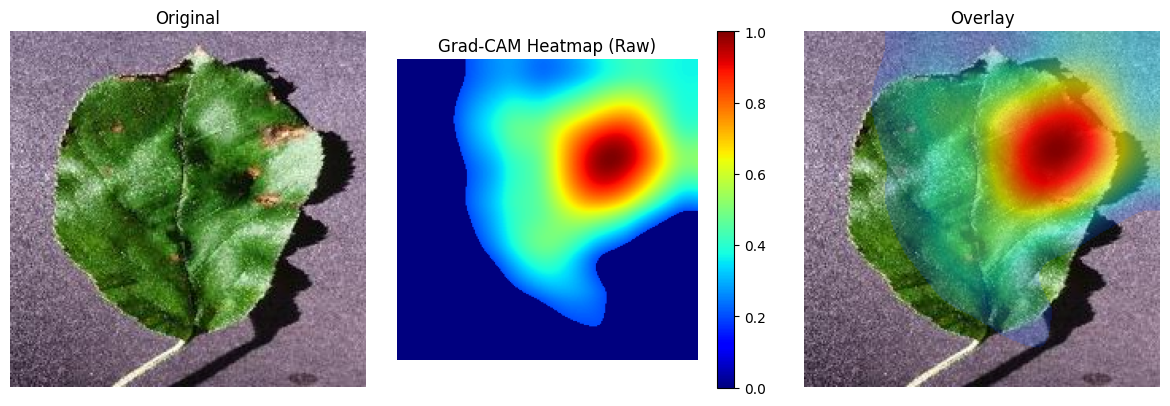

In [49]:
save_path="/content/drive/MyDrive/green/all_dataset/GradCam/EffNet1.jpg"
image_path = "/content/drive/MyDrive/green/all_dataset/test/Apple___Black_rot/8371e040-cf1b-4c28-a52c-db9c10ad9465___JR_FrgE.S 3007.JPG"
model_path = "/content/drive/MyDrive/green/all_dataset/models/best_efficientnet_model.pth"

generate_gradcam(image_path, model_path, class_names, save_path)

Predicted: Apple___Cedar_apple_rust
CAM min: -0.011947599239647388, CAM max: 0.3958679437637329, CAM mean: 0.13525930047035217, CAM std: 0.08938714116811752
Grad-CAM saved to: /content/drive/MyDrive/green/all_dataset/GradCam/EffNet2.jpg


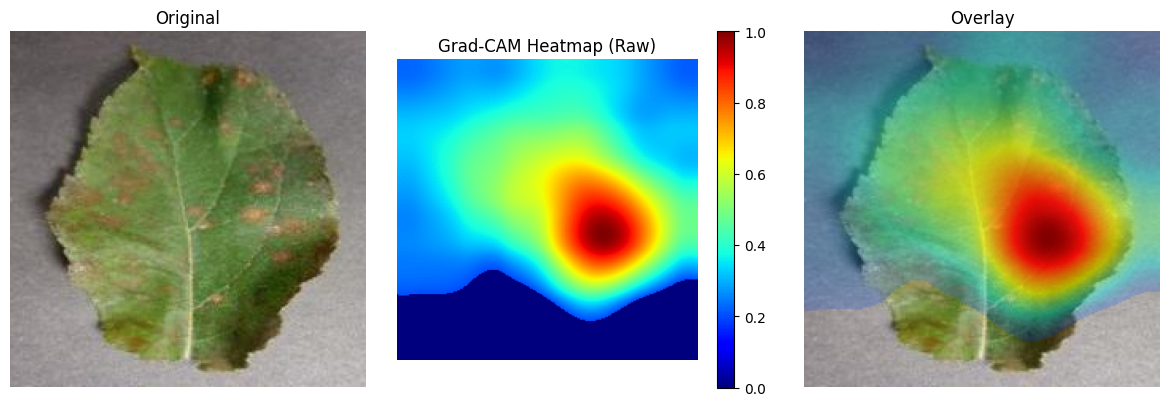

In [50]:
save_path="/content/drive/MyDrive/green/all_dataset/GradCam/EffNet2.jpg"
image_path = "/content/drive/MyDrive/green/all_dataset/test/Apple___Cedar_apple_rust/fb11d069-d664-4666-ab51-3a7a4284e495___FREC_C.Rust 3791.JPG"
model_path = "/content/drive/MyDrive/green/all_dataset/models/best_efficientnet_model.pth"

generate_gradcam(image_path, model_path, class_names,save_path)

Predicted: Tomato___Bacterial_spot
CAM min: -0.02195257507264614, CAM max: 0.22843554615974426, CAM mean: 0.08695008605718613, CAM std: 0.04860944300889969
Grad-CAM saved to: /content/drive/MyDrive/green/all_dataset/GradCam/EffNet3.jpg


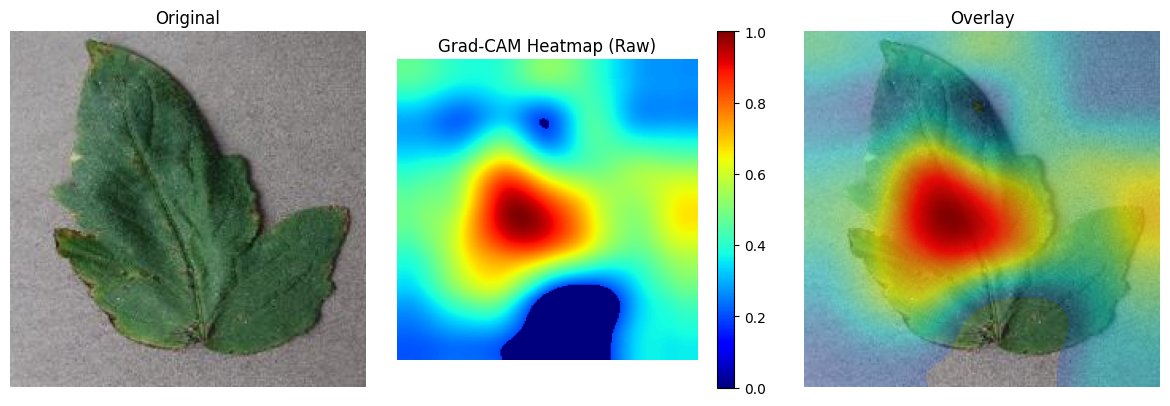

In [51]:
save_path="/content/drive/MyDrive/green/all_dataset/GradCam/EffNet3.jpg"
image_path = "/content/drive/MyDrive/green/all_dataset/test/Tomato___Bacterial_spot/5a6b8e29-8841-4529-bcf5-08a69ffc07ed___GCREC_Bact.Sp 6353.JPG"
model_path = "/content/drive/MyDrive/green/all_dataset/models/best_efficientnet_model.pth"

generate_gradcam(image_path, model_path, class_names, save_path)

Predicted: Tomato___Tomato_Yellow_Leaf_Curl_Virus
CAM min: -0.017664726823568344, CAM max: 0.5155785083770752, CAM mean: 0.24220159649848938, CAM std: 0.1389039009809494
Grad-CAM saved to: /content/drive/MyDrive/green/all_dataset/GradCam/EffNet4.jpg


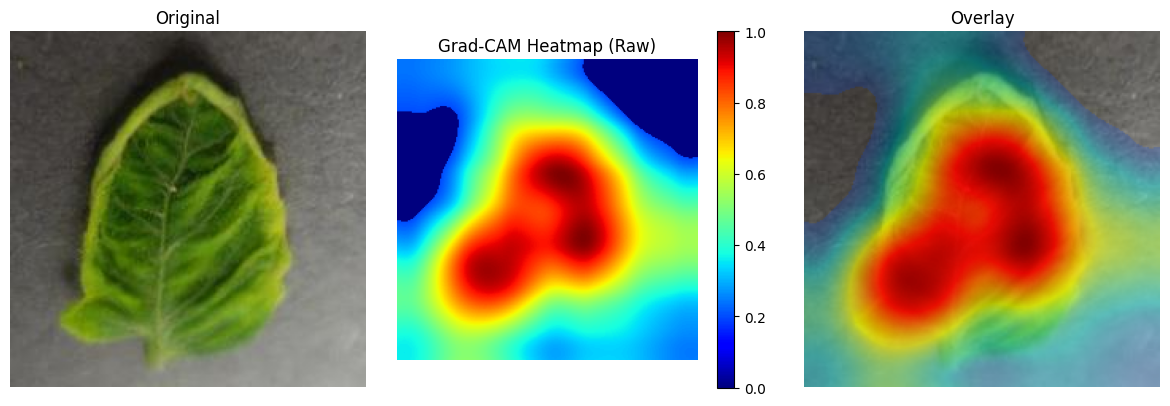

In [52]:
save_path="/content/drive/MyDrive/green/all_dataset/GradCam/EffNet4.jpg"
image_path = "/content/drive/MyDrive/green/all_dataset/test/Tomato___Tomato_Yellow_Leaf_Curl_Virus/277c0191-b251-41be-9f5f-7954e3744a08___UF.GRC_YLCV_Lab 03381.JPG"
model_path = "/content/drive/MyDrive/green/all_dataset/models/best_efficientnet_model.pth"

generate_gradcam(image_path, model_path, class_names, save_path)

Predicted: Peach___healthy
CAM min: -0.013759526424109936, CAM max: 0.1298089623451233, CAM mean: 0.027702318504452705, CAM std: 0.0396692231297493
Grad-CAM saved to: /content/drive/MyDrive/green/all_dataset/GradCam/EffNet5.jpg


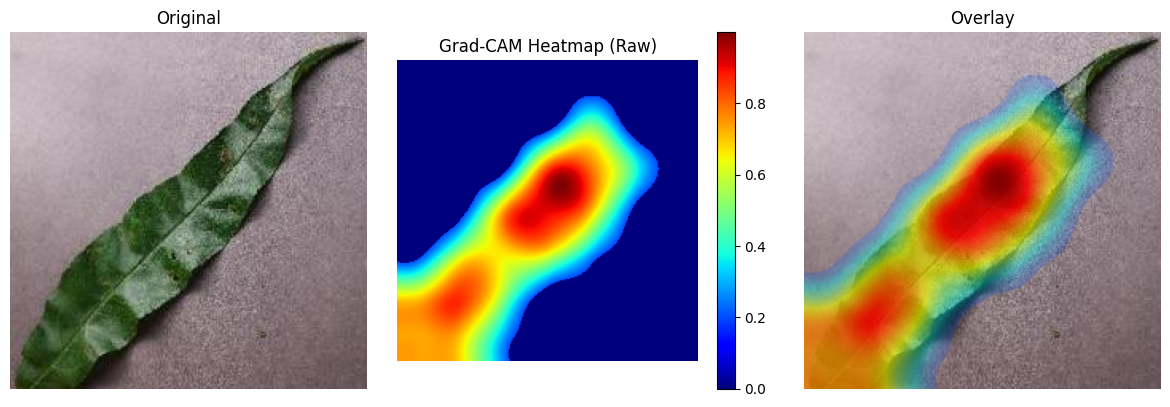

In [53]:
save_path="/content/drive/MyDrive/green/all_dataset/GradCam/EffNet5.jpg"
image_path = "/content/drive/MyDrive/green/all_dataset/test/Peach___Bacterial_spot/254ec5b7-89ce-4f7b-a435-84d0bc76e620___Rut._Bact.S 1157.JPG"
model_path = "/content/drive/MyDrive/green/all_dataset/models/best_efficientnet_model.pth"

generate_gradcam(image_path, model_path, class_names, save_path)

In [76]:
import os

path = "/content/drive/MyDrive/green/all_dataset/test/Peach___Bacterial_spot"
files = os.listdir(path)
for f in files:
    print(f)


c06c81e1-be94-42d0-b0ce-9592dfe5212c___Rutg._Bact.S 1711.JPG
42df2a58-50ee-4d01-8769-5b207594c239___Rut._Bact.S 1503.JPG
a9e1db85-2df4-457a-a962-4c76d0b555b4___Rutg._Bact.S 2192.JPG
8707fb49-a347-47a1-a60c-f96826d63a56___Rutg._Bact.S 1526.JPG
b2b66ec2-c3a8-4bd1-95c9-6e4f6f55bd20___Rutg._Bact.S 1557.JPG
8f8e4075-b775-441a-acac-c230b781088e___Rutg._Bact.S 1285.JPG
f8372db2-cbab-4f19-956a-e7b1041f9efe___Rut._Bact.S 1511.JPG
5685671b-cce8-45dd-a446-0d1e85374154___Rutg._Bact.S 2185.JPG
9f7c97e6-d9ff-4a31-a38a-30aeb4a2eeec___Rut._Bact.S 1067.JPG
923aab96-363a-49b8-9122-9b97134c418a___Rut._Bact.S 1514.JPG
7e7bb696-3508-4292-a49c-a943fff0b0cf___Rutg._Bact.S 1350.JPG
e182422a-b48e-4d07-8b2e-3fb0f4d9ad13___Rutg._Bact.S 2204.JPG
c8549cbc-a220-4a0d-8dab-8b886f6200df___Rutg._Bact.S 2130.JPG
d6d654e0-fcb6-49bd-a0d8-5795342720db___Rut._Bact.S 1439.JPG
bcd812c2-b193-48cc-85d4-38cc3e83bbb8___Rutg._Bact.S 1543.JPG
b76c43c7-a0d3-43ca-b172-46cfbc192739___Rutg._Bact.S 2169.JPG
6583dbb4-3d11-4a73-b06e-6eba2